LOGISTIC REGRESSION MODEL 

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV    


In [2]:
import pandas as pd

# Load your datasets
approx_entropy_df = pd.read_csv('Combined_Entropy.csv')
entropy_per_channel_df = pd.read_csv('eeg_entropy_features.csv')
frequency_features_df = pd.read_csv('eeg_frequency_features.csv')

# Merge all datasets on Patient_ID
combined_data = approx_entropy_df.merge(entropy_per_channel_df, on="Patient_ID",how='left')
combined_data = combined_data.merge(frequency_features_df, on="Patient_ID",how='left')

# Merge with suffixes to keep track of Label columns
combined_data = approx_entropy_df.merge(entropy_per_channel_df, on="Patient_ID", how='left', suffixes=('', '_entropy'))
combined_data = combined_data.merge(frequency_features_df, on="Patient_ID", how='left', suffixes=('', '_frequency'))

# Check if 'Label_entropy' and 'Label_frequency' columns are identical to 'Label'
if 'Label_entropy' in combined_data.columns and (combined_data['Label'] == combined_data['Label_entropy']).all():
    combined_data = combined_data.drop(columns=['Label_entropy'])
if 'Label_frequency' in combined_data.columns and (combined_data['Label'] == combined_data['Label_frequency']).all():
    combined_data = combined_data.drop(columns=['Label_frequency'])

print(combined_data.head(1))
print(combined_data.shape)
print(combined_data['Label'].value_counts())



    Patient_ID  Label       Fp1       Fp2        F3        F4        C3  \
0  v1p_v1p.csv      1  1.642273  1.399319  1.788776  1.385568  1.894291   

         C4        P3        P4  ...  occipital_theta_avg_power  \
0  1.719796  1.915635  1.512754  ...                 556.439793   

   occipital_alpha_avg_power  occipital_beta_avg_power  \
0                 417.316758                589.752563   

   occipital_gamma_avg_power  temporal_delta_avg_power  \
0                 195.140531                  879.2552   

   temporal_theta_avg_power  temporal_alpha_avg_power  \
0                580.225853                478.095124   

   temporal_beta_avg_power  temporal_gamma_avg_power  \
0               480.728786                 232.60505   

   frontal_parietal_theta_ratio  
0                      0.983045  

[1 rows x 240 columns]
(121, 240)
Label
1    61
0    60
Name: count, dtype: int64


In [3]:
# Separate features and target label
X = combined_data.drop(columns=["Patient_ID", "Label"])
y = combined_data["Label"]


In [4]:
# Assuming combined_data DataFrame, X (features), and y (target) are already defined
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (96, 238)
Shape of y_train: (96,)
Shape of X_test: (25, 238)
Shape of y_test: (25,)


Accuracy: 0.76

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.64      0.78      0.70         9

    accuracy                           0.76        25
   macro avg       0.75      0.76      0.75        25
weighted avg       0.78      0.76      0.76        25



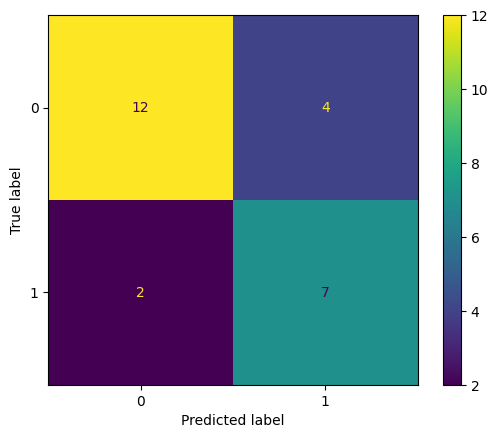

In [6]:
# Initialize and train Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(log_reg_model, X_test, y_test)


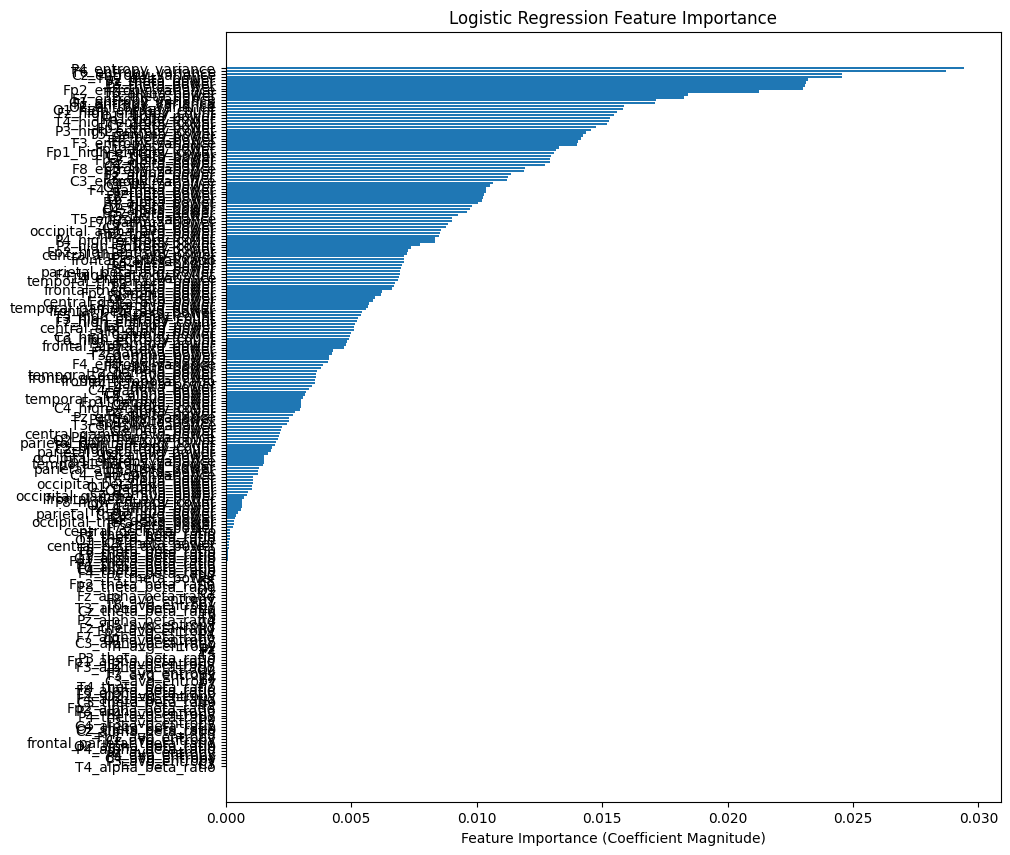

In [7]:
# Calculate feature importance based on coefficients
feature_importances = np.abs(log_reg_model.coef_[0])

# Create a DataFrame to view feature importance in descending order
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Coefficient Magnitude)")
plt.title("Logistic Regression Feature Importance")
plt.show()

In [8]:

def logistic_regression_hypertune(X_train, y_train, X_test, y_test):
    # Define the hyperparameters grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Penalty terms
        'solver': ['liblinear', 'saga'],  # Solvers for logistic regression
        'max_iter': [100, 200, 500]  # Number of iterations
    }

    # Initialize the Logistic Regression model
    log_reg = LogisticRegression()

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        cv=5,  # Number of cross-validation folds
        scoring='accuracy',
        verbose=2,
        n_jobs=-1  # Use all available cores
    )

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Score:", best_score)

    # Retrieve the best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)
    print("Tuned Model Accuracy on Test Set:", accuracy_score(y_test, y_pred))
    print("\nClassification Report for Tuned Model:\n", classification_report(y_test, y_pred))

    # Display the confusion matrix
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

    return best_model  # Return the best model for further use

# Now, you can call this function with your data


Fitting 5 folds for each of 120 candidates, totalling 600 fits


C:\Users\smrit\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\smrit\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\smrit\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\smrit\AppData\Roaming\Python\Python312\site

Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Score: 0.76
Tuned Model Accuracy on Test Set: 0.84

Classification Report for Tuned Model:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.73      0.89      0.80         9

    accuracy                           0.84        25
   macro avg       0.83      0.85      0.83        25
weighted avg       0.86      0.84      0.84        25



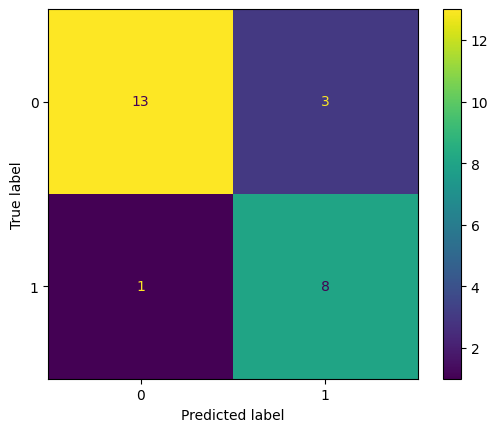

In [9]:
best_logistic_model = logistic_regression_hypertune(X_train, y_train, X_test, y_test)


c:\Users\smrit\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



SHAP Summary Plot for Class 0 (Control)


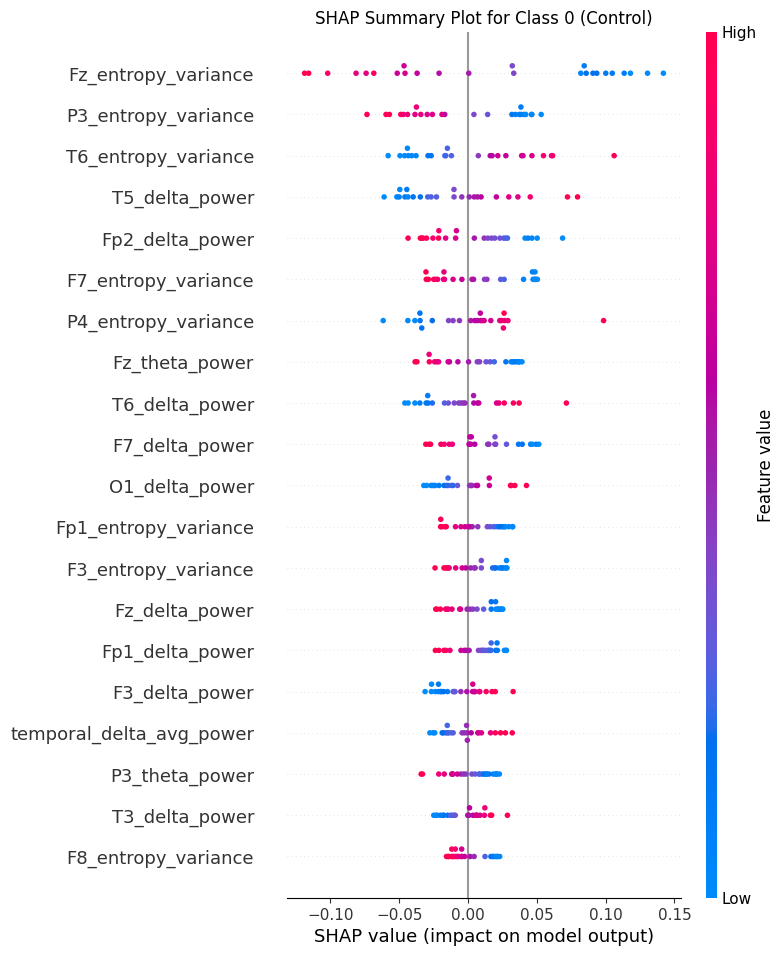


SHAP Summary Plot for Class 1 (ADHD)


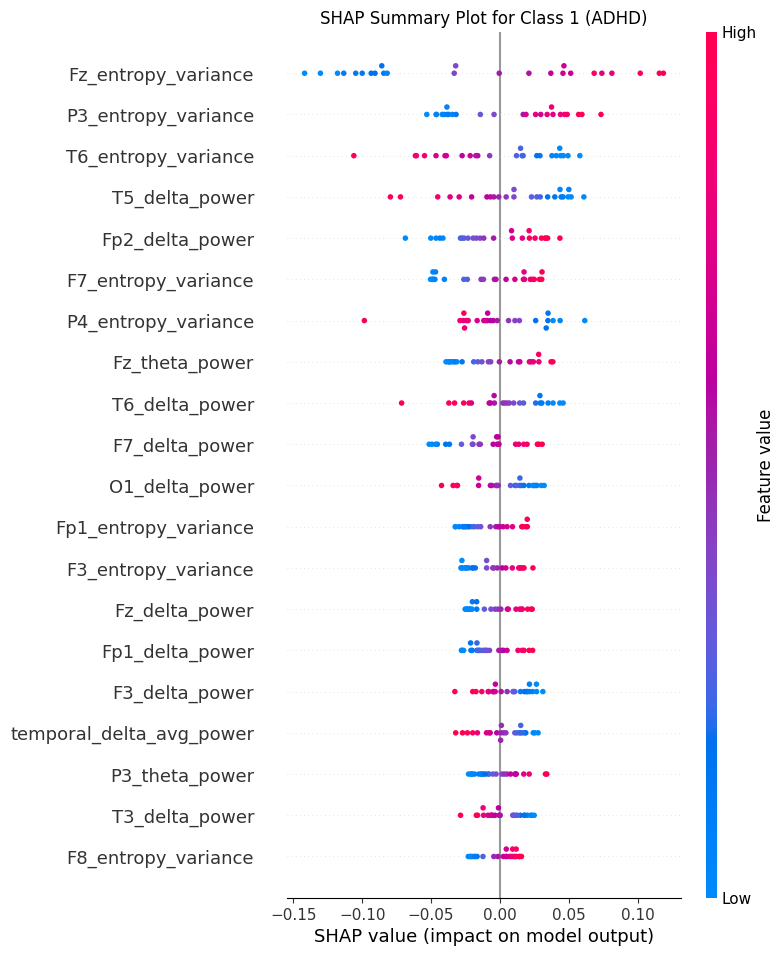

In [10]:
import shap
import matplotlib.pyplot as plt
feature_names = X_train.columns.tolist()  # Get feature names from the training set
target_names = ['Control', 'ADHD']  # Modify these names based on your dataset's labels

# Initialize SHAP explainer for a binary classification model
explainer = shap.Explainer(best_logistic_model.predict_proba, X_train)
shap_values = explainer(X_test)

# Loop through both classes (binary classification)
for class_label in range(2):
    print(f"\nSHAP Summary Plot for Class {class_label} ({target_names[class_label]})")

    # Extract SHAP values for the specific class
    class_shap_values = shap_values.values[:, :, class_label]
    
    # Plot SHAP summary for this class
    shap.summary_plot(class_shap_values, X_test,
                      feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot for Class {class_label} ({target_names[class_label]})")
    plt.show()


c:\Users\smrit\miniconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\smrit\miniconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\smrit\miniconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

C:\Users\smrit\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\smrit\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Explanation for Instance: 0
Predicted Class: 0
Probability of Predicted Class: 0.7918850790587666
Local Feature Importance:
Fz_entropy_variance <= 2480.50: -0.1740563740579163
T6_entropy_variance <= 2512.01: 0.08549267259655532
P3_entropy_variance <= 2525.44: -0.07435606187424307
F7_entropy_variance <= 2501.22: -0.06586887158658122
T5_delta_power <= 717.55: 0.06306261588630857
Fp2_delta_power <= 1023.16: -0.06268789963863054
T6_delta_power <= 786.39: 0.05625399476113634
Fz_theta_power <= 537.39: -0.049721495909429314
F7_delta_power <= 883.51: -0.04702412914605105
temporal_delta_avg_power <= 928.19: 0.03346790515272125


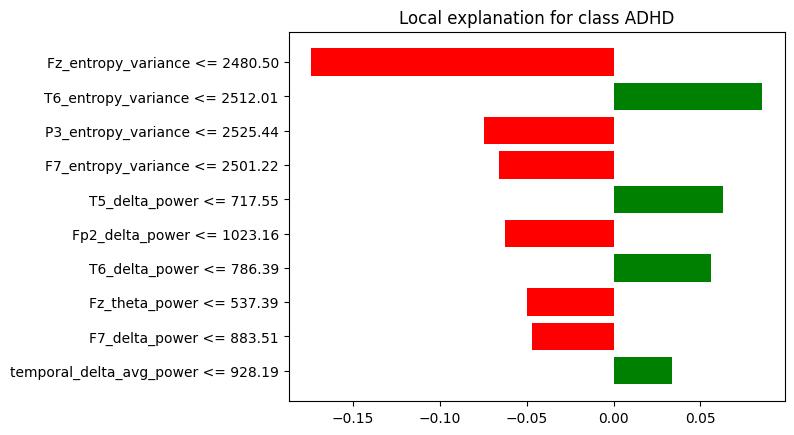

In [11]:
import lime
import lime.lime_tabular
import numpy as np

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Control', 'ADHD'],  # Adjust based on your label names
    mode='classification'
)
instance_index = 0
instance = X_test.iloc[instance_index]

# Choose a test instance to explain
exp = explainer.explain_instance(X_test.iloc[instance_index], best_logistic_model.predict_proba, num_features=10)


exp.show_in_notebook(show_table=True)

print("Explanation for Instance:", instance_index)
print("Predicted Class:", best_logistic_model.predict([instance])[0])
print("Probability of Predicted Class:", np.max(best_logistic_model.predict_proba([instance])))
print("Local Feature Importance:")

for feature_name, weight in exp.as_list():
  print(f"{feature_name}: {weight}")
import matplotlib.pyplot as plt

# Customize the plot's background color
fig = exp.as_pyplot_figure()
fig.patch.set_facecolor('white')  # Change the background color to white

# Show the plot
plt.show()


